<div style="display: flex; background-color: RGB(255,114,0); padding: 30px;" >

# La poste - chargement du modèle et test
</div>

In [1]:
import tensorflow as tf
from keras import layers, Sequential, Input
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.utils import plot_model
import os
from os import getcwd

from PIL import Image
import pandas as pd

from IPython.display import clear_output

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from laposte_model_creation import *

# load and show an image with Pillow
from PIL import Image

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [2]:
verbose=0

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Chargement des données
</div>

In [3]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
if "projet_laposte" not in file_path:
    file_path = join(file_path, "projet_laposte")

print(f"Execution path : {file_path}")

source_data_path = join(file_path,"data")
print("Source path :", source_data_path)

checkpoint_path = join(file_path,"model","ckpt")
print(f"checkpoint_path : {checkpoint_path}")

model_save_path = join(file_path,'model','my_model')
print(f"model_save_path : {model_save_path}")

Execution path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_laposte\
Source path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_laposte\data
checkpoint_path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_laposte\model\ckpt
model_save_path : c:\Users\User\WORK\workspace-ia\PROJETS\projet_laposte\model\my_model


In [4]:
# récupération données
img_extensions = [".jpg", ".jpeg", ".png"]
img_extensions = [".png"]
images = []

for ext in img_extensions:
    images.extend(get_dir_files(source_data_path, endwith=ext))

print(len(images), "images")

33 images


In [5]:
img_size = (28,28)

In [6]:
x_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=0)
x_test

array([], shape=(0, 28, 28), dtype=float64)

In [7]:
x_test = None
y_test = None

009-test_pc_009.png (28, 28) arr ==>  (28, 28)


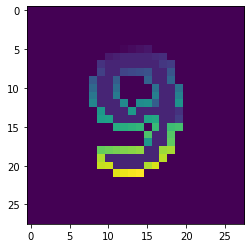

Image max = 68 for 255


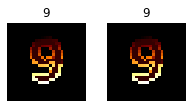

(31, 28, 28)
(31,)


In [8]:
apply_contrast = True
x_test = None
y_test = None
verbose = 1

for img_name in images:
    try:
        clear_output(wait=False)
        # Open the image form working directory
        # image = Image.open(join(source_data_path, img_name))
        img_path = join(source_data_path, img_name)
        image = Image.open(img_path)  
        print(img_name, image.size, end="")
        
        label = int(img_name[0:3])
        # Retailler les images pour les forcer en 28x28.
        if image.size != img_size:
            image = image.resize(img_size)
            print(img_name, image.size, end="")

        # summarize some details about the image
        # arr = np.array(image.getdata(), dtype=np.uint8)
        arr = np.array(image) # Transformation de l'image en tableau numpy
        arr = arr.astype(int)
        
        arr = arr.reshape(image.size)
        print(" arr ==> ", arr.shape)
        if verbose>0:
            plt.imshow(arr)
            plt.show()
            # show_digit(arr, label)

        if apply_contrast:
            arr2 = contraste_img(arr=arr, verbose=verbose)
            if verbose>0:
                # plt.imshow(arr2)
                # plt.show()
                tp1 = arr.reshape(1,-1)
                tp2 = arr2.reshape(1,-1)
                
                # colum_label =[f"pixel_{i}" for i in range(0, tp1.shape[1])]
                npa = np.array([tp1[0], tp2[0]])
                # df = pd.DataFrame(data=npa, columns=colum_label)
                df = pd.DataFrame(data=npa)
                draw_digits(df, y=[label, label], nb=2)
            arr = arr2
        if x_test is None:
            x_test= np.array([arr])
            y_test = np.array([label])
        else:
            tt = np.array([arr])
            x_test = np.concatenate((x_test, tt), axis=0)
            y_test = np.append(y_test,np.array([label]))
        

    except Exception as error:
        print(f"ERROR {error} : {img_name}")

print(x_test.shape)
print(y_test.shape)

(31, 28, 28)
(31,)
[draw_digits] 
ERROR on 30 image : num must be 1 <= num <= 30, not 31


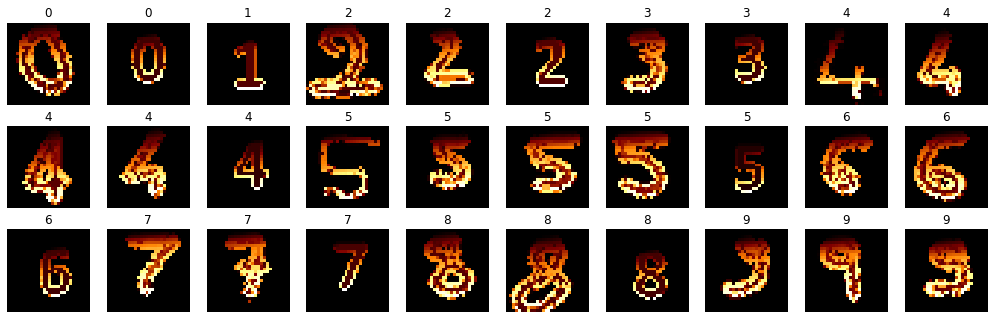

In [9]:
print(x_test.shape)
print(y_test.shape)
draw_digits(df=pd.DataFrame(data=x_test.reshape(x_test.shape[0],-1)), y=y_test)

In [10]:
# Sauvegarde des données pour le cas où il faudrait les recharger
x_test_save = x_test.copy()
y_test_save = y_test.copy()

In [11]:
# Restauration des données pour la suite du traitement
x_test = x_test_save.copy()
y_test = y_test_save.copy()

In [12]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

In [13]:
# pré-processing
x_test, y_test = preprocess_data(x_test, y_test, nb_classes=num_classes, verbose=verbose)
print(x_test.shape)
print(y_test.shape)

[preprocessing]	INFO : x = (31, 28, 28), y = (31,) receive
[preprocessing]	INFO : x = (31, 28, 28, 1), y = (31, 10) after preprocess
(31, 28, 28, 1)
(31, 10)


<div style="display: flex; background-color: Blue; padding: 15px;" >

## 2.Load the model
</div>

In [14]:
model_load = None

if model_save_path is not None and model_load is None:
    # Create a basic model instance
    model_load = tf.keras.models.load_model(model_save_path)
    # Check its architecture
    print(model_load.summary())

    # Evaluate the restored model
    loss, acc = model_load.evaluate(x_test,  y_test, verbose=2)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print(model_load.predict(x_test).shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

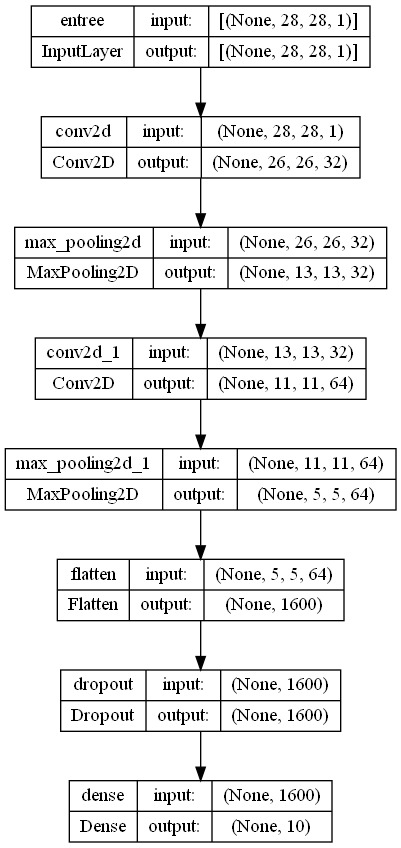

In [15]:
plot_model(model_load, to_file=r"C:\Users\User\WORK\workspace-ia\PROJETS\projet_laposte\img\model_loaded.png", show_shapes=True)

In [16]:
predictions = model_load(x_test[:]).numpy()
print(predictions[0])
print(np.argmax(np.round(predictions[0], 2)))

[5.5627424e-01 9.5817161e-04 8.7231444e-03 2.0567045e-02 4.5106304e-03
 5.4531477e-02 2.0765390e-01 9.0300309e-05 1.0578018e-01 4.0910829e-02]
0


<div style="display: flex; background-color: indigo;" >

#### Visualisation prédictions
</div>

[plot_pred_multiple] 
ERROR on 30 image : num must be 1 <= num <= 60, not 61


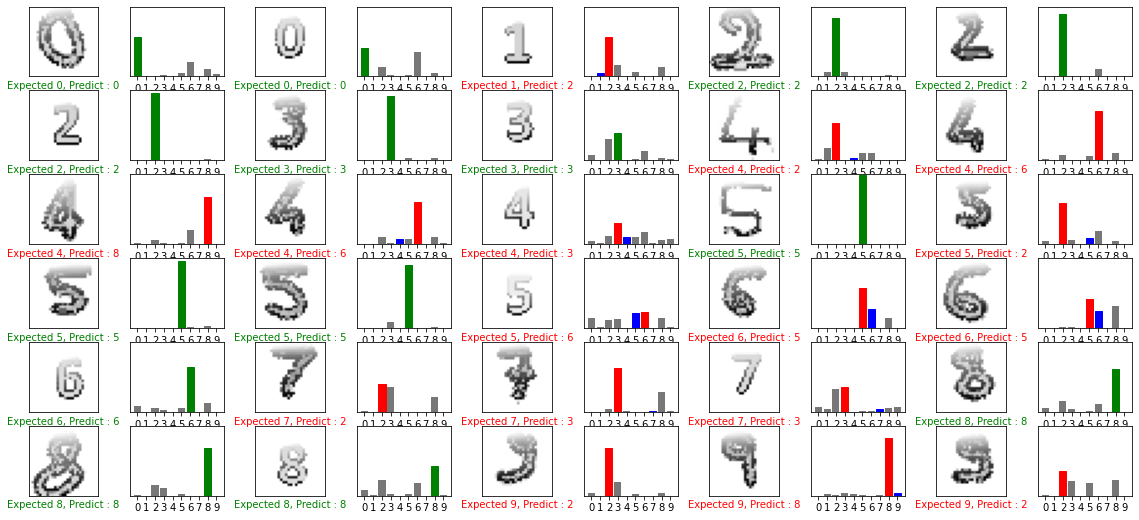

In [17]:
plot_pred_multiple(x=x_test, y=y_test, predictions=predictions, range=range(0,y_test.shape[0]))

In [21]:
error_x = []
error_y = []
error_pred = []

for i in range(0, len(predictions)):
    predictions_array = predictions[i]
    true_label = y_test[i]
    pred = np.round(predictions_array, 2)
    predicted_label = np.argmax(np.round(predictions_array, 2))
    true_label_i = np.argmax(np.round(true_label, 2))

    if predicted_label != true_label_i:
        error_x.append(x_test[i])
        error_pred.append(predictions_array)
        error_y.append(true_label)

17 x en error, 17 y en error, 17 pred en error
[plot_pred_multiple] 
ERROR on 15 image : num must be 1 <= num <= 30, not 31
[plot_pred_multiple] 
ERROR on 16 image : num must be 1 <= num <= 30, not 31


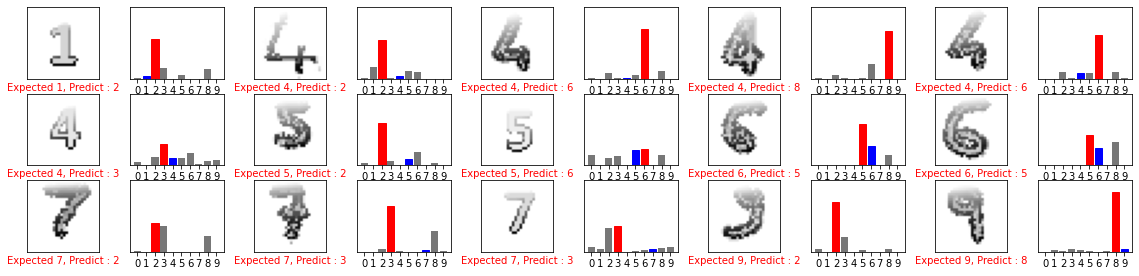

In [27]:
print(f"{len(error_x)} x en error, {len(error_y)} y en error, {len(error_pred)} pred en error")
plot_pred_multiple(x=error_x, y=error_y, predictions=error_pred, range=range(0,len(error_y)))

En appliquant le constrate il y a une erreur de moins au total, mais les erreurs ne sont pas toutes sur les mêmes images :
|Label | File                    | Contrast | Without contrast|
|------|-------------------------|----------|-----------------|
|0     |`000-test_pc_000`        |          |             FAIL|
|1     |`001-test_pc_001`        |      FAIL|                 |
|3     |`003-test_pc_003`        |          |             FAIL|
|4     |`004-damien_004-28x28`   |      FAIL|             FAIL|
|4     |`004-test_manuel_004-001`|      FAIL|             FAIL|
|4     |`004-test_manuel_004-002`|      FAIL|             FAIL|
|4     |`004-test_manuel_004-003`|      FAIL|             FAIL|
|4     |`004-test_pc_004`        |      FAIL|             FAIL|
|5     |`005-test_manuel_005-003`|      FAIL|             FAIL|
|5     |`005-test_pc_005`        |      FAIL|                 |
|6     |`006-test_manuel_006-001`|      FAIL|             FAIL|
|6     |`006-test_manuel_006-002`|      FAIL|             FAIL|
|7     |`007-test_manuel_007-001`|      FAIL|             FAIL|
|7     |`007-test_manuel_007-002`|      FAIL|             FAIL|
|7     |`007-test_pc_007`        |      FAIL|             FAIL|
|8     |`008-test_pc_008`        |          |             FAIL|
|9     |`009-test_manuel_009-001`|      FAIL|             FAIL|
|9     |`009-test_manuel_009-002`|      FAIL|             FAIL|
|9     |`009-test_manuel_009-003`|      FAIL|             FAIL|
|9     |`009-test_pc_009`        |      FAIL|             FAIL|


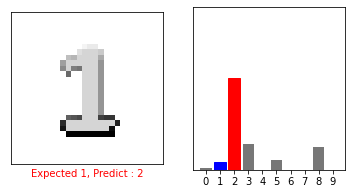

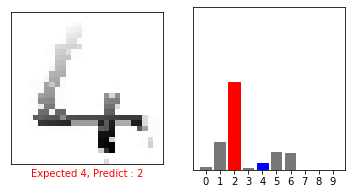

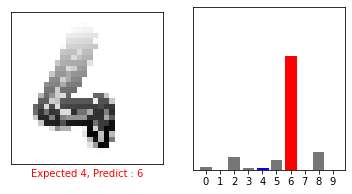

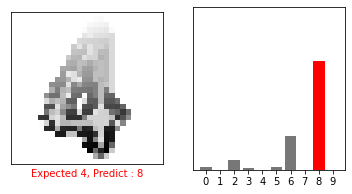

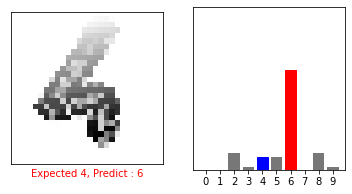

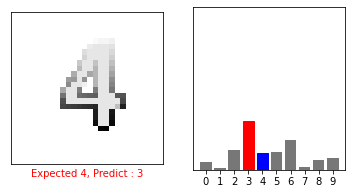

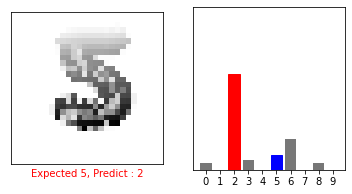

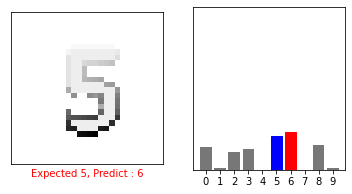

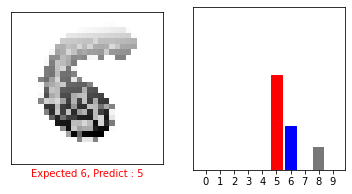

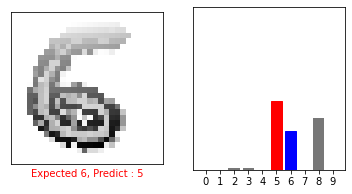

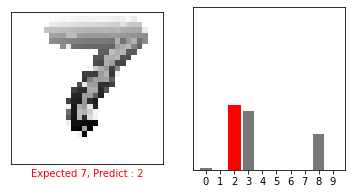

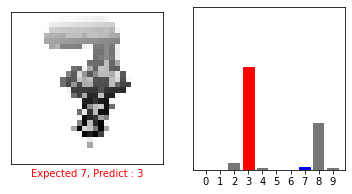

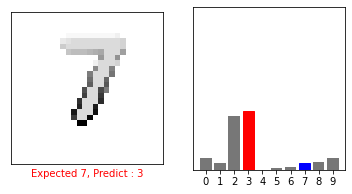

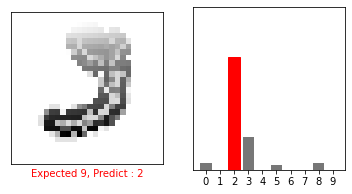

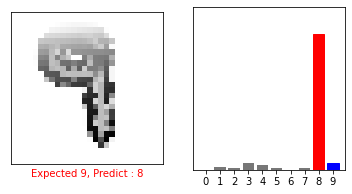

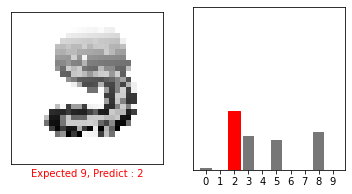

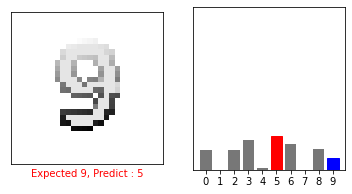

In [26]:
plot_pred(x=error_x, y=error_y, predictions=error_pred, range=range(0,len(error_y)))

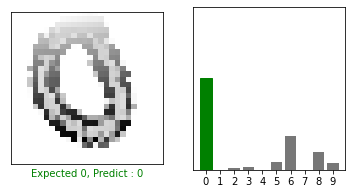

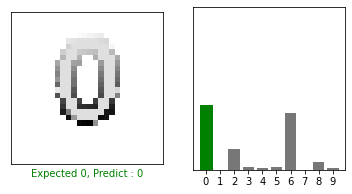

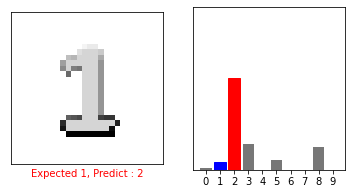

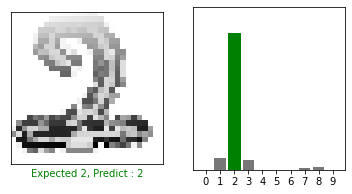

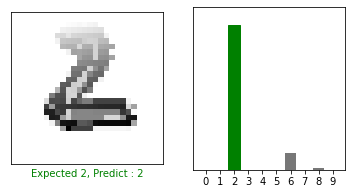

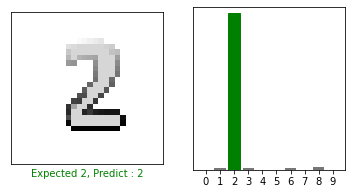

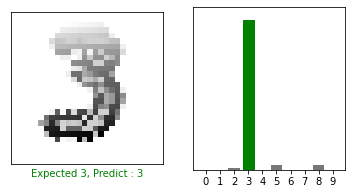

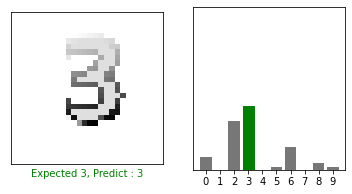

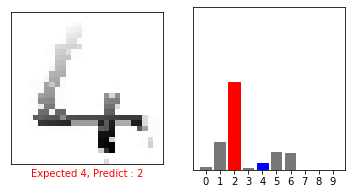

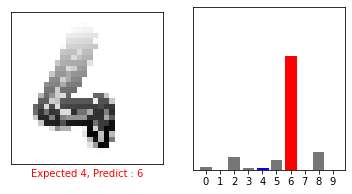

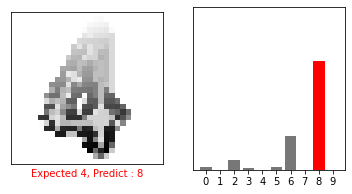

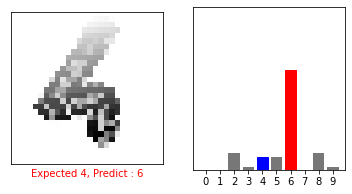

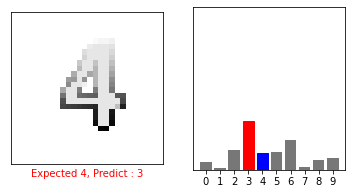

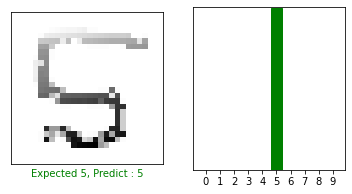

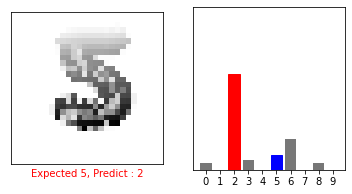

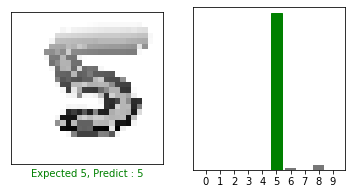

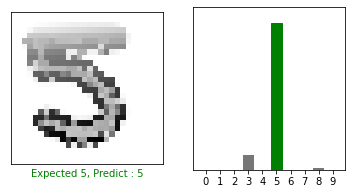

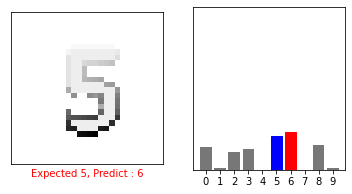

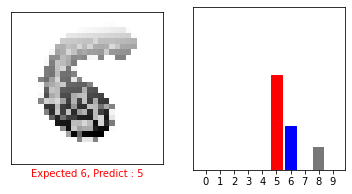

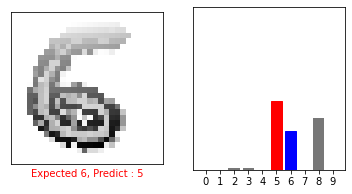

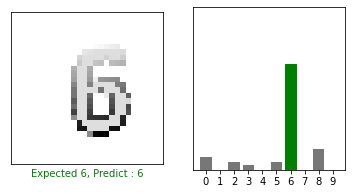

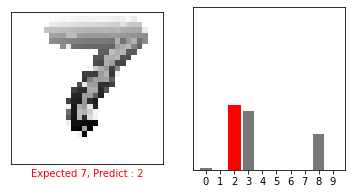

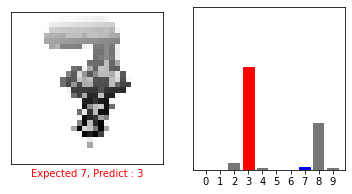

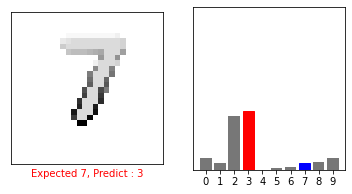

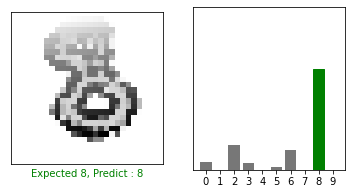

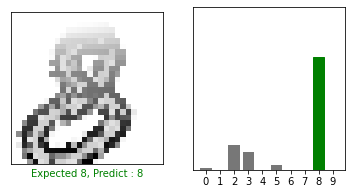

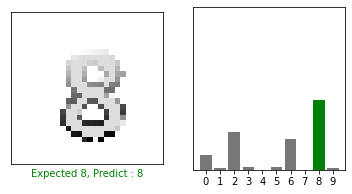

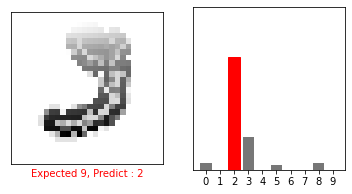

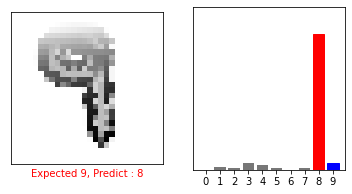

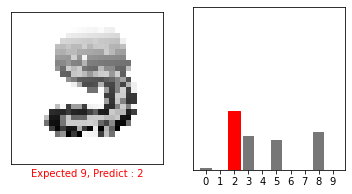

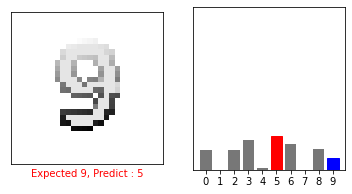

In [24]:
plot_pred(x=x_test, y=y_test, predictions=predictions, range=range(0,y_test.shape[0]))